**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**SUPERVISED MACHINE LEARNING: ANÁLISE DE REGRESSÃO SIMPLES E MÚLTIPLA**<br>
**Prof. Dr. Luiz Paulo Fávero**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>

*coding: utf-8*

In [1]:
# In[0.1]: Instalação dos pacotes

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests

In [2]:
# In[0.2]: Importação dos pacotes

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import matplotlib.image as mpimg # carregar imagem 
import plotly.graph_objects as go # gráficos 3D
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise; Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos - https://stats-tests.github.io/statstests/
from scipy import stats # estatística chi2
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo logístico multinomial
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

##### CONCEITOS

**Probabilidade**:<br> 
- p = evento
- 1-p = não evento

**Chance (odds)**:<br>
- p / (1-p) "quantos pedaços"

##### MQO/OLS (Regressão Simples e Múltipla)
$\hat{y}_i = \alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i$ 

### Logística Binária
$ln(chance_i) = \alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i$

onde **Logito($Z$)** = $\alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i$<br>
(varia de -$\infty$ a +$\infty$)

$\therefore$<br>
$ln(\frac{p_i}{1-p_i}) = Z$<br>
$\frac{p_i}{1-p_i} = e^Z$<br>
$p_i.(1+e^Z) = e^Z$<br>
$p_i = \frac{e^Z}{1+e^Z}$<br>
$p_i = \frac{1}{1+e^-Z}$<br>
$p_i = \frac{1}{1+e^-(\alpha + (\beta_1 . X_1)_i + (\beta_2 . X_2)_i + ... + (\beta_k . X_k)_i)}$ 

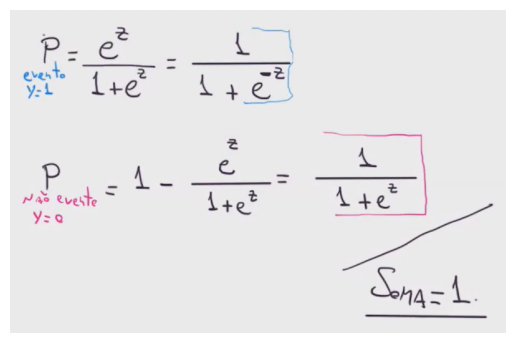

In [3]:
# Complementar
# Carregar a imagem
img = mpimg.imread('assets/output_conceito_log_bin.png')

# Exibir a imagem
#plt.figure(figsize=(6,5))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

### Logística Multinomial

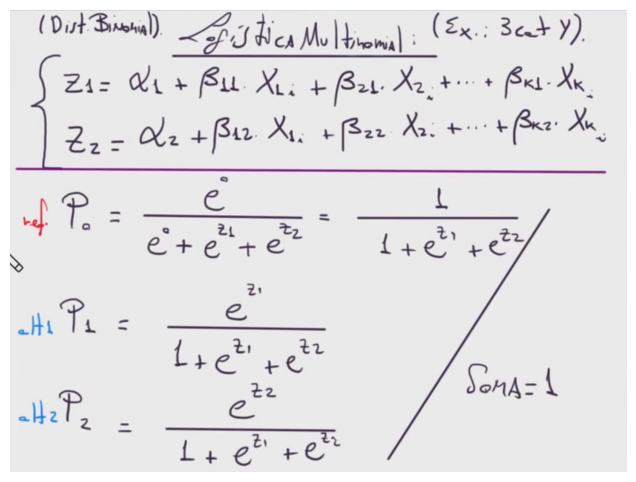

In [4]:
# Complementar
# Carregar a imagem
img = mpimg.imread('assets/output_conceito_log_multi.png')

# Exibir a imagem
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

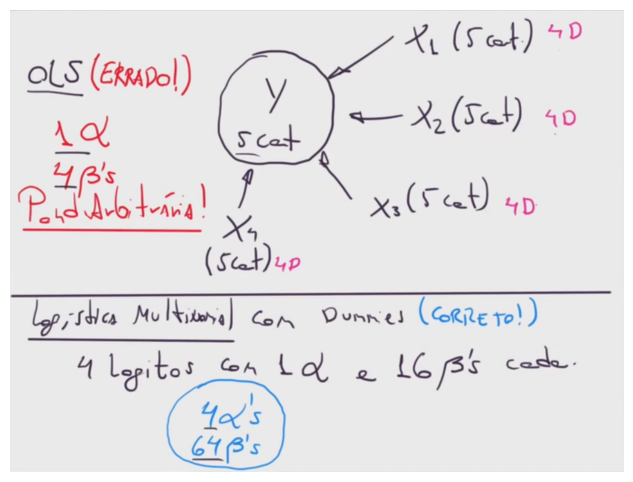

In [5]:
# Complementar
# Carregar a imagem
img = mpimg.imread('assets/output_conceito_log_multi_2.png')

# Exibir a imagem
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

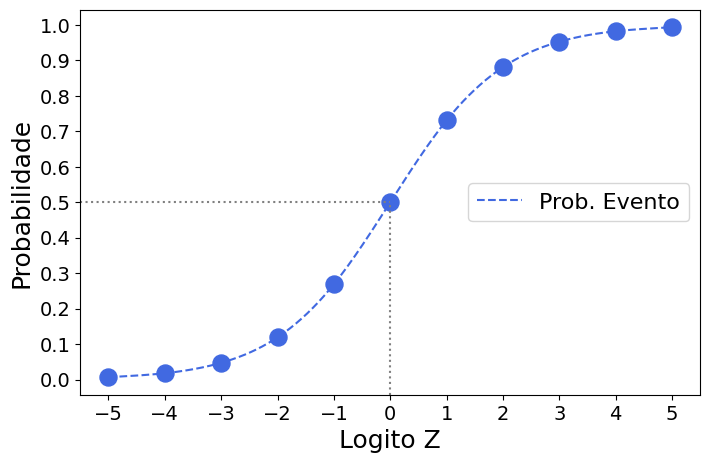

In [6]:
# In[PARTE CONCEITUAL]:
#############################################################################
#                             CURVA SIGMOIDE                                #
#############################################################################

# Estabelecendo uma função para a probabilidade de ocorrência de um evento

from math import exp

# Estabelecendo uma função para a probabilidade de ocorrência de um evento
def prob(z):
    return 1 / (1 + exp(-z))

# In[SIGMOIDE]: Plotando a curva sigmoide teórica de ocorrência de um evento
#para um range do logito z entre -5 e +5

logitos = []
probs = []

for i in np.arange(-5, 6):
    logitos.append(i)
    probs.append(prob(i))
    
df = pd.DataFrame({'logito': logitos, 'probs': probs})

# Interpolação spline (smooth probability line)
spline = UnivariateSpline(df['logito'], df['probs'], s=0)

logitos_smooth = np.linspace(df['logito'].min(), df['logito'].max(), 500)
probs_smooth = spline(logitos_smooth)

plt.figure(figsize=(8,5))
plt.plot(logitos_smooth, probs_smooth, color='royalblue',
         linestyle='--', label='Prob. Evento')
plt.scatter(df['logito'], df['probs'], color='royalblue', marker='o', s=150)
plt.axhline(y = df.probs.mean(), color = 'grey', linestyle = ':', xmax = .5)
plt.axvline(x = 0, color = 'grey', linestyle=':', ymax = 0.5)
plt.xlabel("Logito Z", fontsize=18)
plt.ylabel("Probabilidade", fontsize=18)
plt.xticks(np.arange(-5, 6), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend(fontsize=16, loc='center right')
plt.show()

Assíntotas em 0 e 1 (nunca ultrapassam esses valores)

In [7]:
# In[EXEMPLO 1]:
#############################################################################
#                      REGRESSÃO LOGÍSTICA BINÁRIA                          #                  
#               EXEMPLO 1 - CARREGAMENTO DA BASE DE DADOS                   #
#############################################################################

df_atrasado = pd.read_csv('data/atrasado.csv',delimiter=',')
df_atrasado.head(3)

,estudante,atrasado,dist,sem
0,Gabriela,0,12.5,7
1,Patricia,0,13.3,10
2,Gustavo,0,13.4,8


In [8]:
# Características das variáveis do dataset
df_atrasado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    int64  
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [9]:
# Estatísticas univariadas
df_atrasado.describe()

,atrasado,dist,sem
count,100.000000,100.000000,100.000000
mean,0.590000,14.073000,10.210000
std,0.494311,4.330112,1.578229
min,0.000000,1.000000,5.000000
25%,0.000000,12.000000,10.000000
50%,1.000000,13.350000,10.000000
75%,1.000000,16.125000,10.000000
max,1.000000,29.000000,18.000000


In [10]:
# In[1.1]: Tabela de frequências absolutas da variável 'atrasado'

df_atrasado['atrasado'].value_counts().sort_index()

atrasado
0    41
1    59
Name: count, dtype: int64

In [11]:
# In[1.2]: Estimação de um modelo logístico binário pela função 'smf.glm'
#('statsmodels.formula.api')

modelo_atrasos = smf.glm(formula='atrasado ~ dist + sem', data=df_atrasado,
                         family=sm.families.Binomial()).fit()

# Parâmetros do 'modelo_atrasos'
print(modelo_atrasos.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               atrasado   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.466
Date:                Mon, 16 Sep 2024   Deviance:                       100.93
Time:                        20:30:03   Pearson chi2:                     86.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2913
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.1665      8.442     -3.100      0.0

Onde o *Log-Likelihood* serve como medidor de eficiência do modelo, uma vez que calcula a contribuição de cada observação para maximizar a somatória. 

In [12]:
# In[1.3]: Outputs do modelo pela função 'summary_col'

sc = summary_col([modelo_atrasos],
            model_names=["MODELO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.3f}".format(x.llf)
        })

print(sc)


             MODELO  
---------------------
Intercept -26.1665***
          (8.4420)   
dist      0.1904**   
          (0.0764)   
sem       2.3629***  
          (0.7951)   
N         100        
Log-lik   -50.466    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


In [13]:
# In[1.4]: Fazendo predições para o 'modelo_atrasos'.

#Exemplo: qual a probabilidade média de se chegar atrasado quando o
#trajeto tem 7 km e passa-se por 10 semáforos no percurso?

modelo_atrasos.predict(pd.DataFrame({'dist':[7], 'sem':[10]}))

0    0.230566
dtype: float64

Probabilidade de aprox. 23%

In [14]:
# Confirmando com cálculo manual:
prob = (1)/(1 + np.exp(-(-26.1665 + 0.1904*7 + 2.3629*10)))
prob

0.23064016805378282

In [15]:
# In[1.5]: Construção de uma matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_atrasado['phat'] = modelo_atrasos.predict()

# Visualização da base de dados com a variável 'phat'
df_atrasado

,estudante,atrasado,dist,sem,phat
0,Gabriela,0,12.5,7,0.000712
1,Patricia,0,13.3,10,0.498561
2,Gustavo,0,13.4,8,0.008903
3,Leticia,0,23.5,7,0.005751
4,Luiz Ovidio,0,9.5,8,0.004257
...,...,...,...,...,...
95,Sheila,1,24.0,10,0.884040
96,Pedro,1,10.0,10,0.346606
97,Horacio,1,9.4,10,0.321210
98,Leandro,1,14.2,10,0.541301


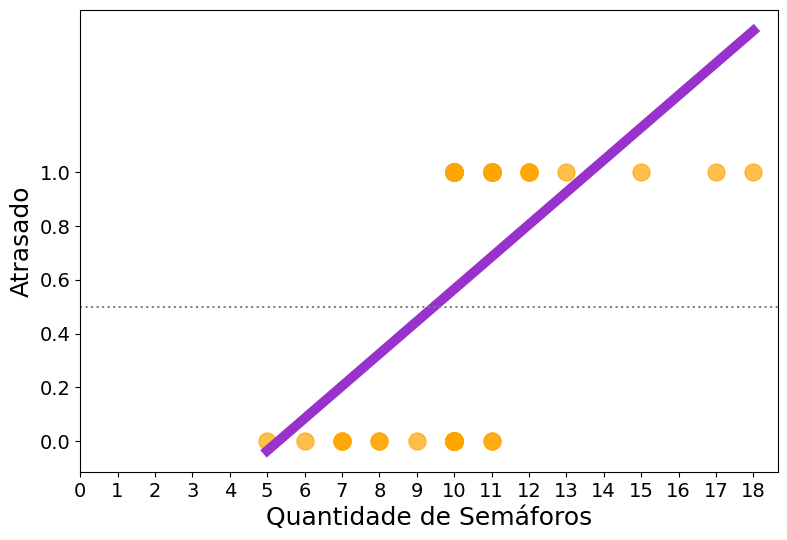

In [16]:
# In[1.6]: Gráficos com ajustes entre a variável dependente e a variável 'sem'
    
# Ajuste linear entre a variável dependente e a variável 'sem' (GRÁFICO ERRADO:
# APENAS PARA FINS DIDÁTICOS)

plt.figure(figsize=(9,6))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o',
            scatter_kws={'color':'orange', 's':150, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=18)
plt.ylabel('Atrasado', fontsize=18)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

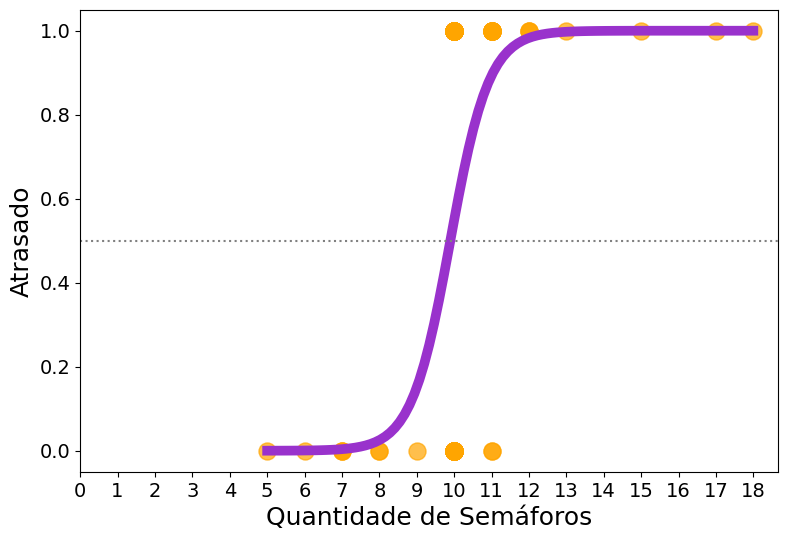

In [17]:
# In[1.7]: Ajuste logístico determinístico entre a variável dependente e a
#variável 'sem'

# Sigmoide

plt.figure(figsize=(9,6))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o', logistic=True, # ACRESCENTA logistic=True
            scatter_kws={'color':'orange', 's':150, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=18)
plt.ylabel('Atrasado', fontsize=18)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

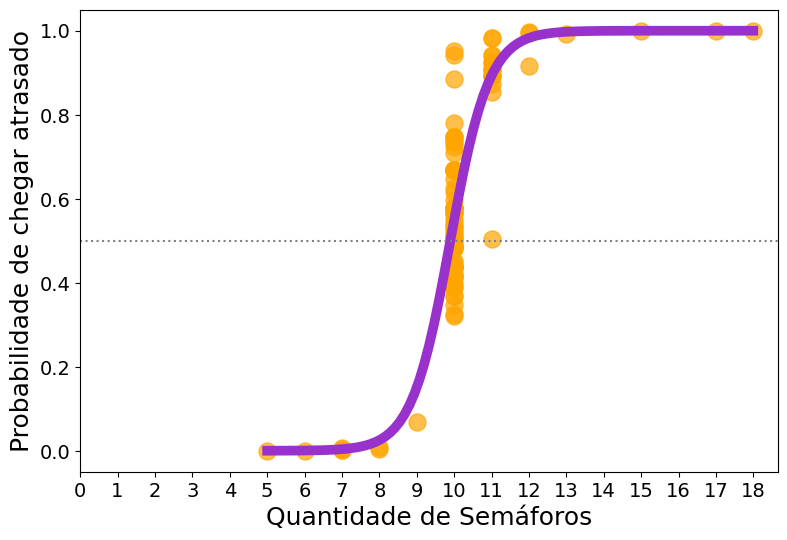

In [18]:
# In[1.8]: Ajuste logístico probabilístico entre a variável dependente e a
#variável 'sem'

# Sigmoide

plt.figure(figsize=(9,6))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['phat'],
            ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':150, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=18)
plt.ylabel('Probabilidade de chegar atrasado', fontsize=18)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

Daí, analisano a probabilidade para determinar um evento ou não evento definimos arbitrariamete um *cutoff* (ponto de corte):
- Se phat >= *cutoff*, temos um **evento**
- Se phat < *cutoff*, temos um **não evento**

Exemplo: se definimos *cutoff* = 0.5, então:
- prob de 0.3 = não evento
- prob de 0.5 = evento
- prob de 0.8 = evento
A partir daí comparamos com a variável quali original (e vemos se a predição acertou ou não)

In [19]:
# In[1.9]: Construção de função para a definição da matriz de confusão

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
          
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    # Visualização dos principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

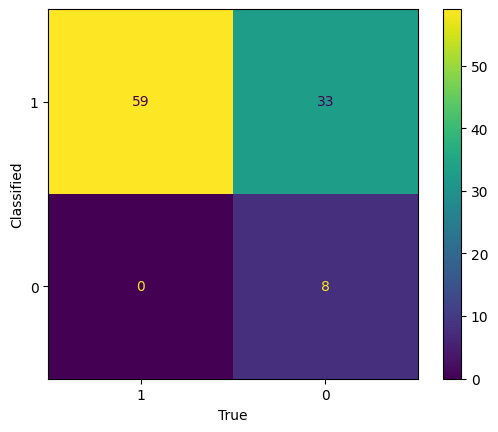

,Sensitividade,Especificidade,Acurácia
0,1.0,0.195122,0.67


In [20]:
# In[1.10]: Matrizes de confusão propriamente ditas

# Matriz de confusão para cutoff = 0.3
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.3)

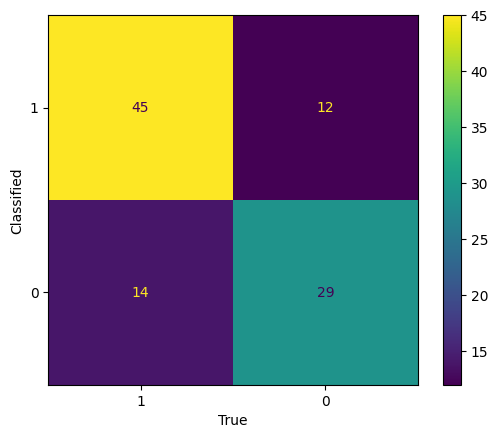

,Sensitividade,Especificidade,Acurácia
0,0.762712,0.707317,0.74


In [21]:
# Matriz de confusão para cutoff = 0.52
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.52)

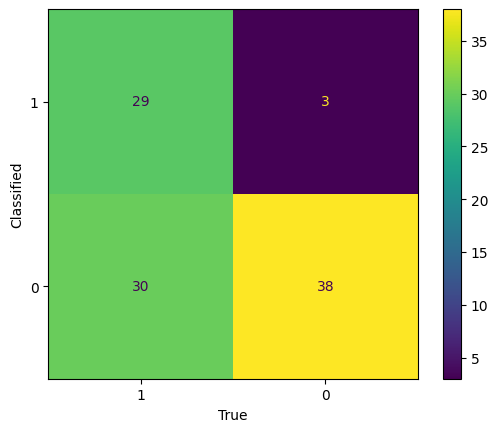

,Sensitividade,Especificidade,Acurácia
0,0.491525,0.926829,0.67


In [22]:
# Matriz de confusão para cutoff = 0.7
matriz_confusao(observado=df_atrasado['atrasado'],
                predicts=df_atrasado['phat'], 
                cutoff=0.7)

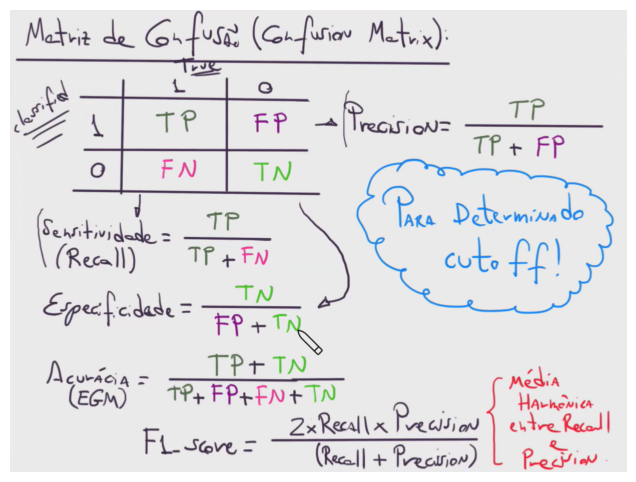

In [23]:
# Complementar
# Carregar a imagem
img = mpimg.imread('assets/output_1.10.png')

# Exibir a imagem
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

Acima, um resumo dos indicadores/ das estatísticas que **dependem** do *cutoff*

In [24]:
# In[1.11]: Igualando critérios de especificidade e de sensitividade

# Tentaremos estabelecer um critério que iguale a probabilidade de
#acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de
#acerto daqueles que não chegarão atrasados (especificidade).

# ATENÇÃO: o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA
#FORMA, o procedimento garante a maximização da acurácia do modelo!

# Criação da função 'espec_sens' para a construção de um dataset com diferentes
#valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # Adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # Range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [25]:
# In[1.12]: Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados (dataframe 'dados_plotagem')

dados_plotagem = espec_sens(observado = df_atrasado['atrasado'],
                            predicts = df_atrasado['phat'])
dados_plotagem.iloc[45:60]

,cutoffs,sensitividade,especificidade
45,0.45,0.830508,0.463415
46,0.46,0.830508,0.487805
47,0.47,0.830508,0.487805
48,0.48,0.830508,0.512195
49,0.49,0.796610,0.585366
50,0.50,0.779661,0.609756
51,0.51,0.762712,0.682927
52,0.52,0.762712,0.707317
53,0.53,0.745763,0.707317
54,0.54,0.728814,0.731707


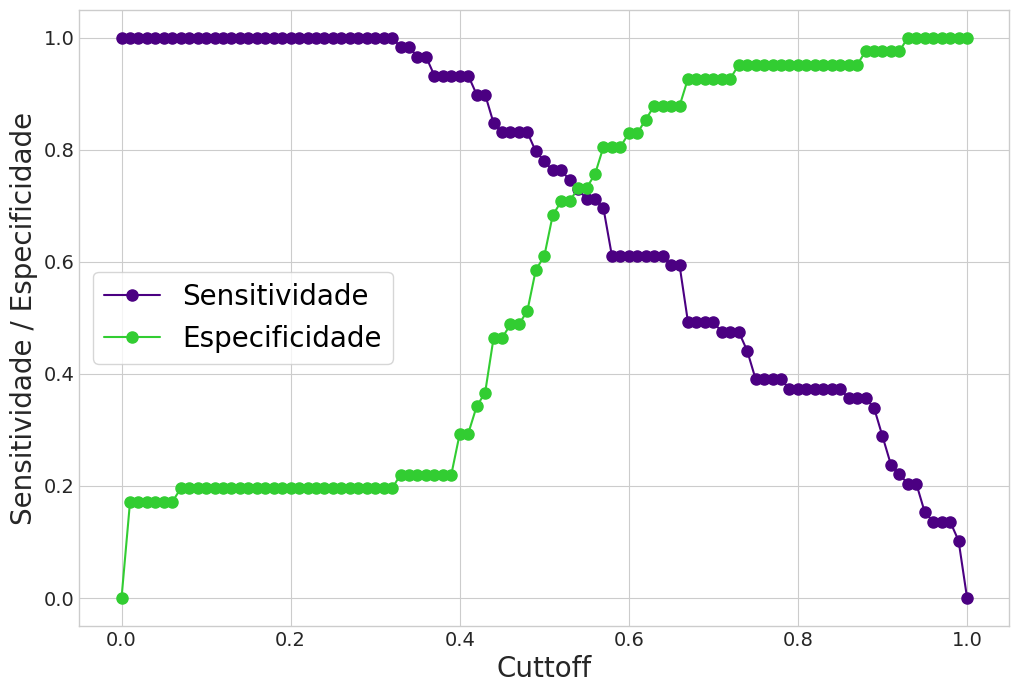

In [26]:
# In[1.13]: Plotagem de um gráfico que mostra a variação da especificidade e da
#sensitividade em função do cutoff

plt.figure(figsize=(12,8))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

OBS: Nem sempre o ponto de encontro é o cutoff que maximiza acurácia!<br>
OBS 2: Nem sempre queremos maximizar a acurácia.<br>
OBS 3: O *cutoff*/*threshhold* geralmente é definido a priori de acordo com o objetivo de maximização.

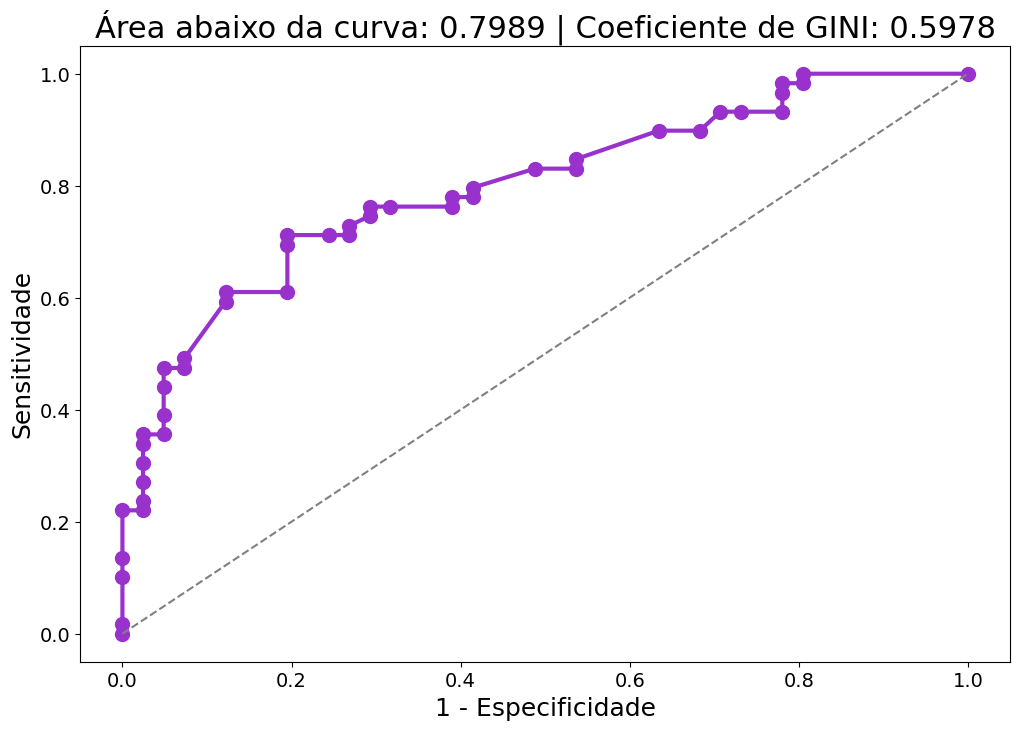

In [27]:
# In[1.14]: Construção da curva ROC

# Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds = roc_curve(df_atrasado['atrasado'], df_atrasado['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=18)
plt.ylabel('Sensitividade', fontsize=18)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

Cada ponto roxo nesse *plot* é um *cutoff*.<br>
A linha pontilhada se chama *guess* (chute/classificador aleatório) e é o divisor de águas entre modelos que melhoram ou pioram as predições. <br>
A curva roxa sendo observada é a **Curva ROC** (*Receiver Operating Characteristic*)
A área abaixo da curva (**AUC**) independe do *cutoff*, ela é ditada pela quantidade de variáveis que permanecem no modelo após o procedimento stepwise. Quanto maior, melhor!

O **índice de GINI** é uma relação entre a área acima da *guess* com a área abaixo da *guess*:

$GINI = \frac{ROC -0.5}{0.5}$

Funciona como outro indicador: Quanto maior, melhor! (Quando a ROC for 1, GINI também será 1)

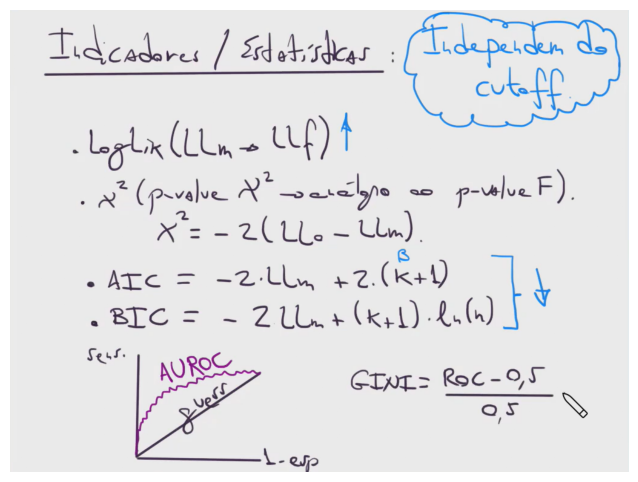

In [28]:
# Complementar
# Carregar a imagem
img = mpimg.imread('assets/output_1.14.png')

# Exibir a imagem
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.show()

Acima, um resumo dos indicadores/ das estatísticas que **independem** do *cutoff*

In [29]:
# In[EXEMPLO 2]:
#############################################################################
#           REGRESSÃO LOGÍSTICA BINÁRIA E PROCEDIMENTO STEPWISE             #        
#                EXEMPLO 2 - CARREGAMENTO DA BASE DE DADOS                  #
#############################################################################

df_challenger = pd.read_csv('data/challenger.csv', delimiter=',')
df_challenger

,desgaste,temperatura,pressão,t
0,0,66,50,1
1,1,70,50,2
2,0,69,50,3
3,0,68,50,4
4,0,67,50,5
5,0,72,50,6
6,0,73,100,7
7,0,70,100,8
8,1,57,200,9
9,1,63,200,10


- desgaste: quantidade de vezes em que ocorreu stress térmico
- temperatura: temperatura de lançamento (graus ºF)
- pressão: pressão de verificação de vazamento (psi: libra-força por polegada ao quadrado)
- t: teste para o lançamento (id)

In [30]:
# Características das variáveis do dataset
df_challenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressão      23 non-null     int64
 3   t            23 non-null     int64
dtypes: int64(4)
memory usage: 864.0 bytes


In [31]:
# Estatísticas univariadas
df_challenger.drop('t', axis=1, inplace=True)
df_challenger.describe()

,desgaste,temperatura,pressão
count,23.000000,23.000000,23.000000
mean,0.304348,69.565217,152.173913
std,0.558796,7.057080,68.221332
min,0.000000,53.000000,50.000000
25%,0.000000,67.000000,75.000000
50%,0.000000,70.000000,200.000000
75%,0.500000,75.000000,200.000000
max,2.000000,81.000000,200.000000


In [32]:
# In[2.1]: Criação da variável dependente binária 'falha'

# Não há uma variável binária para servir como uma variável dependente, certo?
# Então vamos criá-la, considerando a ocorrência de desgastes de peças como a
# ocorrência de um evento que chamaremos de 'falha':

df_challenger.loc[df_challenger['desgaste'] != 0 , 'falha'] = 1
df_challenger.loc[df_challenger['desgaste'] == 0, 'falha'] = 0

# Transformando a variável 'falha' para o tipo 'int' (poderia também deixar
#como 'float'), a fim de que seja possível estimar o modelo por meio da
#função 'sm.Logit.from_formula'

#df_challenger.info()

df_challenger['falha'] = df_challenger['falha'].astype('int64')

#df_challenger.info()

df_challenger.head(3)

,desgaste,temperatura,pressão,falha
0,0,66,50,0
1,1,70,50,1
2,0,69,50,0


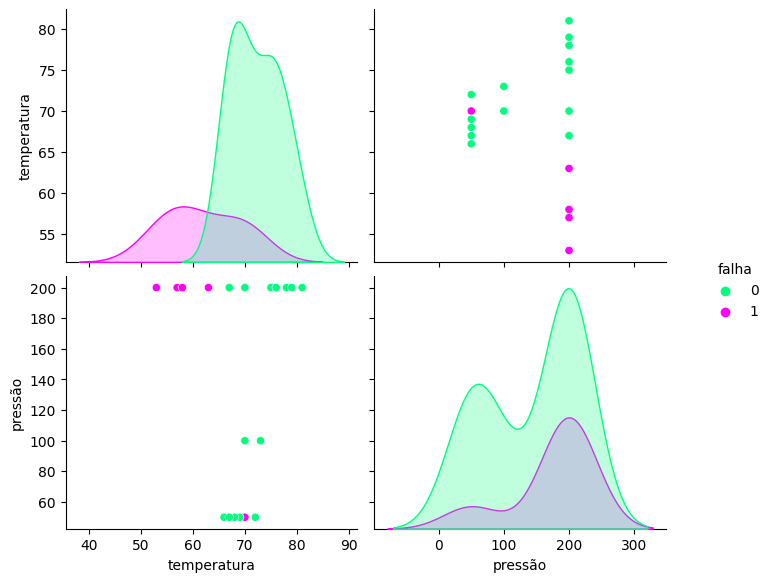

In [33]:
# In[2.2]: Gráfico 'pairplot' com scatters e KDEs por 'falha'

cores_desejadas = {0: 'springgreen', 1: 'magenta'}

g = sns.pairplot(df_challenger[['falha','temperatura','pressão']], hue='falha',
                 palette=cores_desejadas)
g.fig.set_size_inches(8, 6)
plt.show()

Observa-se as médias de temperatura e pressao são maiores para as situações em que não houve falha.<br>
Há multicolinearidade entre as duas (grandes chances de uma delas ficar de fora do modelo final pelo procedimento *stepwise*).

In [34]:
# In[2.3]: Estimação do modelo logístico binário pela função 'sm.Logit.from_formula'
#('statsmodels.api')

# O modelo a seguir também pode ser estimado por meio da função 'smf.glm'
#('statsmodels.formula.api')

modelo_challenger = sm.Logit.from_formula('falha ~ temperatura + pressão',
                                          df_challenger).fit()

# Parâmetros do 'modelo_challenger'
print(modelo_challenger.summary())

Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Sep 2024   Pseudo R-squ.:                  0.4685
Time:                        20:30:05   Log-Likelihood:                -7.0164
converged:                       True   LL-Null:                       -13.201
Covariance Type:            nonrobust   LLR p-value:                  0.002061
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      21.8436     11.936      1.830      0.067      -1.551      45.239
temperatura    -0.3501    

In [35]:
# In[2.4]: Procedimento Stepwise

# Estimação do modelo por meio do procedimento Stepwise
step_challenger = stepwise(modelo_challenger, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 falha ~ Q('temperatura') + Q('pressão')
Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8

 Discarding atribute "Q('pressão')" with p-value equal to 0.5378022290437207 

Estimating model...: 
 falha ~ Q('temperatura')
Optimization terminated successfully.
         Current function value: 0.313604
         Iterations 8

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('pressão')", 'p-value': 0.5378022290437207}

 Model after stepwise process...: 
 falha ~ Q('temperatura') 

                           Logit Regression Results                           
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Sep 2024   Pseudo 

In [36]:
# Pergunta do Helbert
np.exp(-0.3667) # A cada grau (ºF) que aumenta, a chance de ocorrência de 
                # falha é multiplicada por 0.69 (ou seja, a chance de 
                # falha é 31% menor) EM MÉDIA (lembrando que trata-se de 
                # uma sigmoide)

0.6930175191174569

In [37]:
# In[2.5]: Fazendo predições para o modelo 'step_challenger'

# Exemplo 1: qual a probabilidade média de falha a 70ºF (~21.11ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[70]}))

0    0.130777
dtype: float64

In [38]:
# Exemplo 2: qual a probabilidade média de falha a 77ºF (25ºC)?
step_challenger.predict(pd.DataFrame({'temperatura':[77]}))

0    0.011419
dtype: float64

In [39]:
# Exemplo 3: qual a probabilidade média de falha a 34ºF (~1.11ºC)?
# Temperatura no momento do lançamento
step_challenger.predict(pd.DataFrame({'temperatura':[34]}))

0    0.999988
dtype: float64

In [40]:
# In[2.6]: Atribuindo uma coluna no dataframe para os resultados

df_challenger['phat'] = step_challenger.predict()

df_challenger

,desgaste,temperatura,pressão,falha,phat
0,0,66,50,0,0.394770
1,1,70,50,1,0.130777
2,0,69,50,0,0.178373
3,0,68,50,0,0.238539
4,0,67,50,0,0.311309
5,0,72,50,0,0.067389
6,0,73,100,0,0.047688
7,0,70,100,0,0.130777
8,1,57,200,1,0.946496
9,1,63,200,1,0.662129


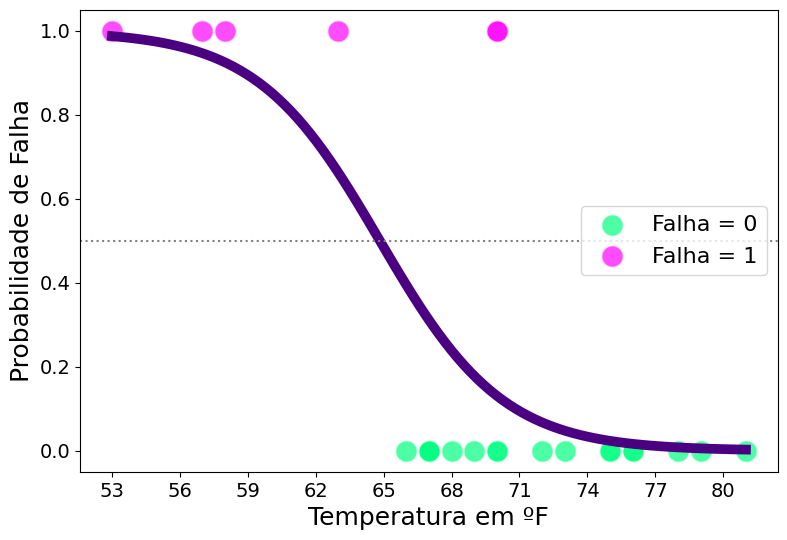

In [41]:
# In[2.7]: Construção da sigmoide
# Probabilidade de evento em função da variável 'temperatura'    

plt.figure(figsize=(9,6))
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 0],
                y=df_challenger['falha'][df_challenger['falha'] == 0],
                color='springgreen', alpha=0.7, s=250, label='Falha = 0')
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 1],
                y=df_challenger['falha'][df_challenger['falha'] == 1],
                color='magenta', alpha=0.7, s=250, label='Falha = 1')
sns.regplot(x=df_challenger['temperatura'], y=df_challenger['falha'],
            logistic=True, ci=None, scatter=False,
            line_kws={'color': 'indigo', 'linewidth': 7})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Temperatura em ºF', fontsize=18)
plt.ylabel('Probabilidade de Falha', fontsize=18)
plt.xticks(np.arange(df_challenger['temperatura'].min(),
                     df_challenger['temperatura'].max() + 0.01, 3),
           fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(fontsize=16, loc='center right')
plt.show()

Apesar de nossa predição no dia do acidente ser uma extrapolação dos intervalos de teste, a chance de falha por volta de 53ºF já era próxima de 100%, portanto, a predição se torna confiável visto que se trata de uma sigmoide.

In [42]:
# In[2.8]: Nossa homenagem aos astronautas

from PIL import Image
import requests
from io import BytesIO

url = "https://img.ibxk.com.br///2016/01/29/29182307148581.jpg?w=1200&h=675&mode=crop&scale=both"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show() 

In [43]:
# In[EXEMPLO 3]:
#############################################################################
#  REGRESSÃO LOGÍSTICA BINÁRIA COM VARIÁVEIS EXPLICATIVAS QUANTI E QUALIS   #
#                EXEMPLO 3 - CARREGAMENTO DA BASE DE DADOS                  #
#############################################################################

df_fidelidade = pd.read_csv('data/dados_fidelidade.csv',delimiter=',')
df_fidelidade.head(3)

,id,fidelidade,sexo,idade,atendimento,sortimento,acessibilidade,preço
0,1,nao,feminino,34,2,2,1,1
1,2,nao,feminino,34,2,2,1,1
2,3,nao,masculino,34,3,2,4,2


In [44]:
# Características das variáveis do dataset
df_fidelidade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3000 non-null   int64 
 1   fidelidade      3000 non-null   object
 2   sexo            3000 non-null   object
 3   idade           3000 non-null   int64 
 4   atendimento     3000 non-null   int64 
 5   sortimento      3000 non-null   int64 
 6   acessibilidade  3000 non-null   int64 
 7   preço           3000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 187.6+ KB


Necessário transformar em objeto as variáveis quali!

In [45]:
# In[3.1]: Alteração dos tipos das variáveis não quantitativas no dataframe

# Transformação do 'id' para o tipo 'str'
df_fidelidade['id'] = df_fidelidade['id'].astype('str')

# Transformação das variáveis explicativas qualitativas para o tipo 'object'
df_fidelidade['atendimento'] = df_fidelidade['atendimento'].astype('object')
df_fidelidade['sortimento'] = df_fidelidade['sortimento'].astype('object')
df_fidelidade['acessibilidade'] = df_fidelidade['acessibilidade'].astype('object')
df_fidelidade['preço'] = df_fidelidade['preço'].astype('object')

# Características das variáveis do dataset
df_fidelidade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3000 non-null   object
 1   fidelidade      3000 non-null   object
 2   sexo            3000 non-null   object
 3   idade           3000 non-null   int64 
 4   atendimento     3000 non-null   object
 5   sortimento      3000 non-null   object
 6   acessibilidade  3000 non-null   object
 7   preço           3000 non-null   object
dtypes: int64(1), object(7)
memory usage: 187.6+ KB


In [46]:
# Estatísticas univariadas
df_fidelidade.describe()

,idade
count,3000.00000
mean,34.21000
std,1.57058
min,29.00000
25%,34.00000
50%,34.00000
75%,34.00000
max,42.00000


In [47]:
# In[3.2]: Tabela de frequências absolutas das variáveis qualitativas referentes
#aos atributos da loja na percepção dos consumidores

df_fidelidade['fidelidade'].value_counts().sort_index()

fidelidade
nao    1320
sim    1680
Name: count, dtype: int64

In [48]:
df_fidelidade['sexo'].value_counts().sort_index()

sexo
feminino     2400
masculino     600
Name: count, dtype: int64

In [49]:
df_fidelidade['atendimento'].value_counts().sort_index()

atendimento
1     150
2     300
3     750
4    1530
5     270
Name: count, dtype: int64

In [50]:
df_fidelidade['sortimento'].value_counts().sort_index()

sortimento
1     330
2     420
3     570
4    1200
5     480
Name: count, dtype: int64

In [51]:
df_fidelidade['acessibilidade'].value_counts().sort_index()

acessibilidade
1     420
2      90
3    1410
4     240
5     840
Name: count, dtype: int64

In [52]:
df_fidelidade['preço'].value_counts().sort_index()

preço
1     180
2     270
3    1170
4     990
5     390
Name: count, dtype: int64

In [53]:
# In[3.3]: Note que a variável Y 'fidelidade' está definida como objeto
#(PROBLEMA!!!)

# Transformando a variável Y para 0 e 1 e para o tipo 'int' (poderia também
#ser do tipo 'float'), a fim de que seja possível estimar o modelo por meio
#da função 'sm.Logit.from_formula'

df_fidelidade.loc[df_fidelidade['fidelidade']=='sim', 'fidelidade'] = 1
df_fidelidade.loc[df_fidelidade['fidelidade']=='nao', 'fidelidade'] = 0

df_fidelidade['fidelidade'] = df_fidelidade['fidelidade'].astype('int64')

df_fidelidade.head()

,id,fidelidade,sexo,idade,atendimento,sortimento,acessibilidade,preço
0,1,0,feminino,34,2,2,1,1
1,2,0,feminino,34,2,2,1,1
2,3,0,masculino,34,3,2,4,2
3,4,0,feminino,34,4,3,3,3
4,5,0,feminino,34,4,3,1,4


In [54]:
# In[3.4]: Dummizando as variáveis 'atendimento', 'sortimento', 'acessibilidade',
#'preço' e 'sexo'. O código abaixo, automaticamente, fará:
# a) a dummização das variáveis originais;
# b) a remoção das variáveis dummizadas originais;
# c) a definição das categorias de label 1 de cada variável original como
#categorias de referência, por meio do argumento 'drop_first=True'.

df_fidelidade_dummies = pd.get_dummies(df_fidelidade,
                                       columns=['atendimento',
                                                'sortimento',
                                                'acessibilidade',
                                                'preço',
                                                'sexo'],
                                       dtype=int,
                                       drop_first=True)

df_fidelidade_dummies.head()

,id,fidelidade,idade,atendimento_2,atendimento_3,atendimento_4,atendimento_5,sortimento_2,sortimento_3,sortimento_4,sortimento_5,acessibilidade_2,acessibilidade_3,acessibilidade_4,acessibilidade_5,preço_2,preço_3,preço_4,preço_5,sexo_masculino
0,1,0,34,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,34,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,34,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
3,4,0,34,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,5,0,34,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [55]:
# In[3.5]: Estimação do modelo logístico binário

# Sugestão de uso neste caso, dada a existência de muitas dummies no dataframe
# Definição da fórmula utilizada no modelo

lista_colunas = list(df_fidelidade_dummies.drop(columns=['id',
                                                         'fidelidade']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "fidelidade ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  fidelidade ~ idade + atendimento_2 + atendimento_3 + atendimento_4 + atendimento_5 + sortimento_2 + sortimento_3 + sortimento_4 + sortimento_5 + acessibilidade_2 + acessibilidade_3 + acessibilidade_4 + acessibilidade_5 + preço_2 + preço_3 + preço_4 + preço_5 + sexo_masculino


In [56]:
# Modelo propriamente dito
modelo_fidelidade = sm.Logit.from_formula(formula_dummies_modelo,
                                               df_fidelidade_dummies).fit()

# Parâmetros do 'modelo_fidelidade'
print(modelo_fidelidade.summary())

Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             fidelidade   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2981
Method:                           MLE   Df Model:                           18
Date:                Mon, 16 Sep 2024   Pseudo R-squ.:                  0.6241
Time:                        20:30:06   Log-Likelihood:                -773.57
converged:                       True   LL-Null:                       -2057.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -68.9866      6.055    -11.394      0.000     -80.854     -57.120
idade      

In [57]:
# In[3.6]: Procedimento Stepwise

#Estimação do modelo por meio do procedimento Stepwise
step_modelo_fidelidade = stepwise(modelo_fidelidade, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 fidelidade ~ Q('idade') + Q('atendimento_2') + Q('atendimento_3') + Q('atendimento_4') + Q('atendimento_5') + Q('sortimento_2') + Q('sortimento_3') + Q('sortimento_4') + Q('sortimento_5') + Q('acessibilidade_2') + Q('acessibilidade_3') + Q('acessibilidade_4') + Q('acessibilidade_5') + Q('preço_2') + Q('preço_3') + Q('preço_4') + Q('preço_5') + Q('sexo_masculino')
Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9

 Discarding atribute "Q('preço_2')" with p-value equal to 0.788057057780571 

Estimating model...: 
 fidelidade ~ Q('idade') + Q('atendimento_2') + Q('atendimento_3') + Q('atendimento_4') + Q('atendimento_5') + Q('sortimento_2') + Q('sortimento_3') + Q('sortimento_4') + Q('sortimento_5') + Q('acessibilidade_2') + Q('acessibilidade_3') + Q('acessibilidade_4') + Q('acessibilidade_5') + Q('preço_3') + Q('preço_4') + Q('preço_5') + Q('sexo_masculino')
Optimization terminated success

In [58]:
# In[3.7]: Construção de função para a definição da matriz de confusão

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

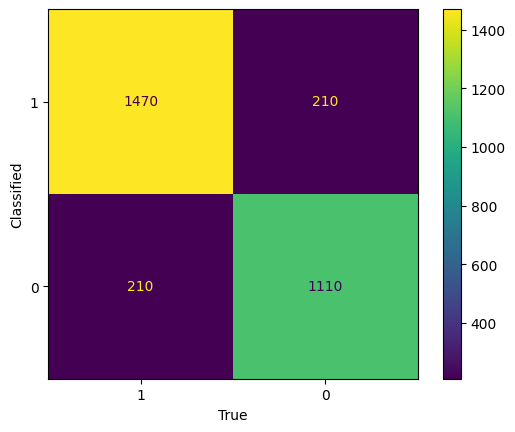

,Sensitividade,Especificidade,Acurácia
0,0.875,0.840909,0.86


In [59]:
# In[3.8]: Construção da matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_fidelidade_dummies['phat'] = step_modelo_fidelidade.predict()

# Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_fidelidade_dummies['fidelidade'],
                predicts=df_fidelidade_dummies['phat'],
                cutoff=0.50)

In [60]:
# In[3.9]: Igualando critérios de especificidade e de sensitividade

# Tentaremos estabelecer um critério que iguale a probabilidade de
#acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de
#acerto daqueles que não chegarão atrasados (especificidade).

# ATENÇÃO: o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA
#FORMA o procedimento garante a maximização da acurácia do modelo!

# Criação da função 'espec_sens' para a construção de um dataset com diferentes
#valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [61]:
# In[3.10]: Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados

dados_plotagem = espec_sens(observado = df_fidelidade_dummies['fidelidade'],
                            predicts = df_fidelidade_dummies['phat'])
dados_plotagem

,cutoffs,sensitividade,especificidade
0,0.00,1.000000,0.000000
1,0.01,1.000000,0.295455
2,0.02,1.000000,0.318182
3,0.03,1.000000,0.340909
4,0.04,1.000000,0.386364
...,...,...,...
96,0.96,0.625000,1.000000
97,0.97,0.517857,1.000000
98,0.98,0.428571,1.000000
99,0.99,0.339286,1.000000


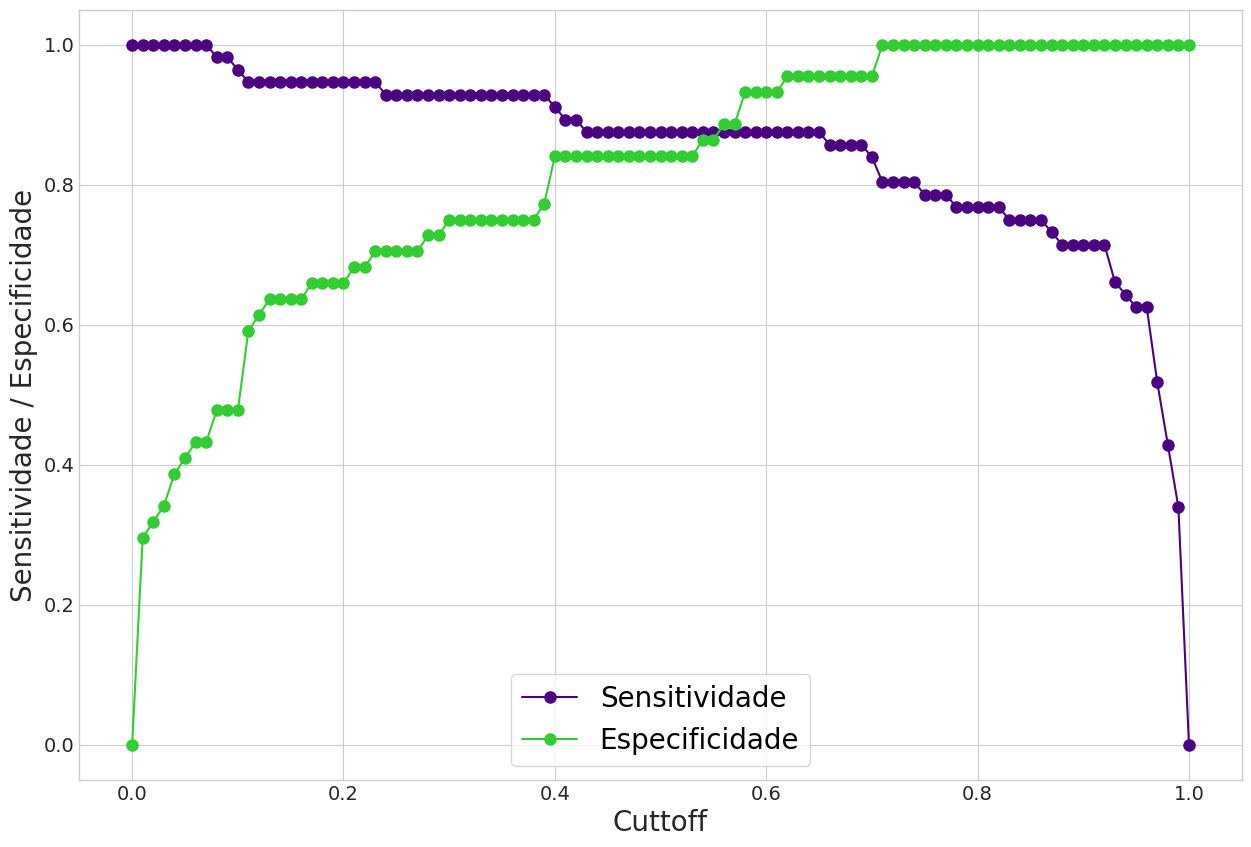

In [62]:
# In[3.11]: Plotagem de um gráfico que mostra a variação da especificidade e da
#sensitividade em função do cutoff

plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

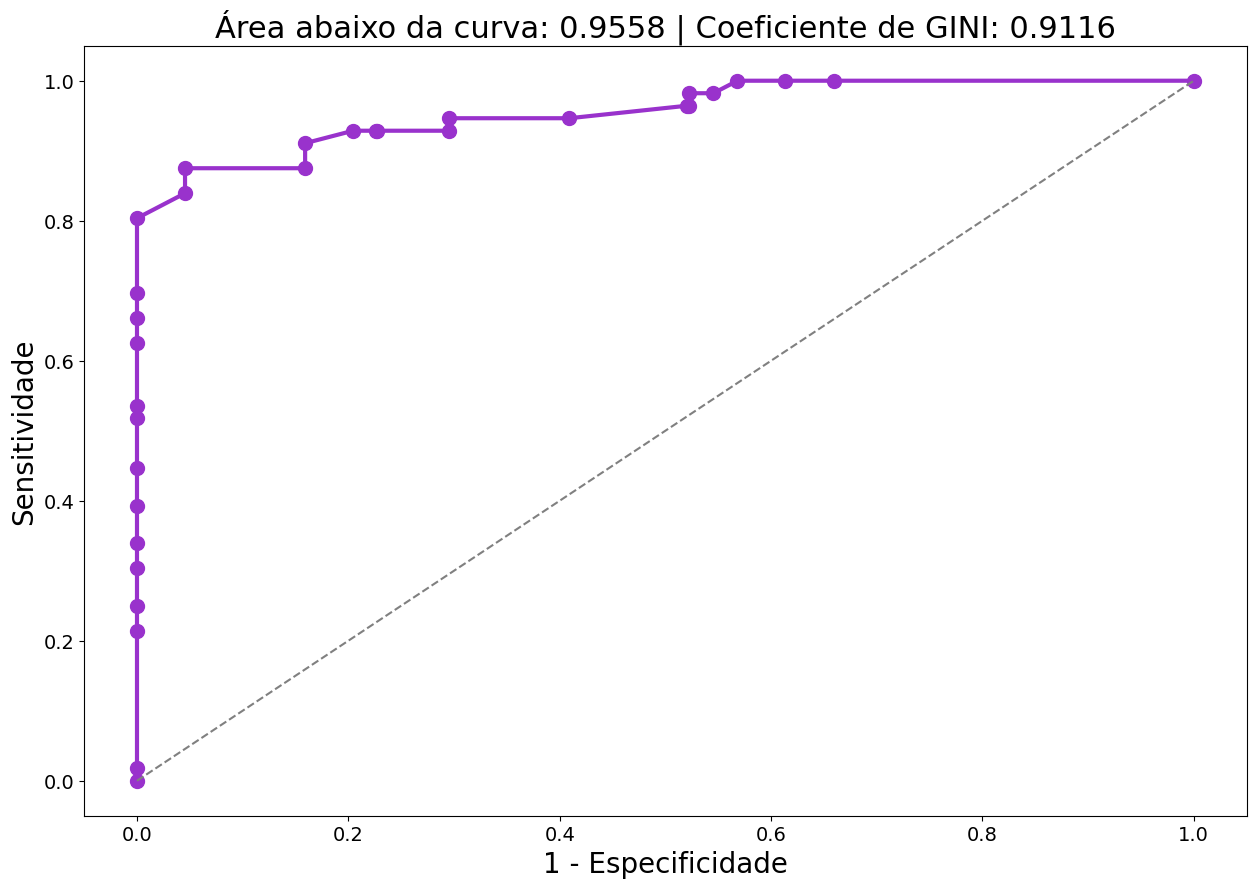

In [63]:
# In[3.12]: Construção da curva ROC

from sklearn.metrics import roc_curve, auc

# Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_fidelidade_dummies['fidelidade'],
                                df_fidelidade_dummies['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensitividade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

In [64]:
# In[EXEMPLO 4]:
#############################################################################
#                      REGRESSÃO LOGÍSTICA MULTINOMIAL                      #
#                 EXEMPLO 4 - CARREGAMENTO DA BASE DE DADOS                 #
#############################################################################

df_atrasado_multinomial = pd.read_csv('data/atrasado_multinomial.csv',delimiter=',')
df_atrasado_multinomial.head(3)

,estudante,atrasado,dist,sem
0,Gabriela,chegou atrasado segunda aula,20.500000,15
1,Patricia,chegou atrasado segunda aula,21.299999,18
2,Gustavo,chegou atrasado segunda aula,21.400000,16


In [65]:
# Características das variáveis do dataset
df_atrasado_multinomial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    object 
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ KB


In [66]:
# Estatísticas univariadas
df_atrasado_multinomial.describe()

,dist,sem
count,100.000000,100.000000
mean,17.673000,13.810000
std,5.130299,3.329376
min,1.000000,10.000000
25%,14.950000,10.000000
50%,18.750000,15.000000
75%,21.000000,18.000000
max,31.500000,19.000000


In [67]:
# In[4.1]: Note que a variável Y 'atrasado' está definida como objeto

# Tabela de frequências absolutas da variável 'atrasado' com labels
df_atrasado_multinomial['atrasado'].value_counts().sort_index()

atrasado
chegou atrasado primeira aula    16
chegou atrasado segunda aula     35
nao chegou atrasado              49
Name: count, dtype: int64

In [68]:
# Criando uma variável 'atrasado2' a partir da variável 'atrasado',
#com labels iguais a 0, 1 e 2 e com tipo 'int' (poderia também ser do tipo
#'float'), a fim de que seja possível estimar o modelo por meio
#da função 'MNLogit' do pacote 'statsmodels.discrete.discrete_model'

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'nao chegou atrasado',
                            'atrasado2'] = 0 #categoria de referência

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado primeira aula',
                            'atrasado2'] = 1

df_atrasado_multinomial.loc[df_atrasado_multinomial['atrasado']==
                            'chegou atrasado segunda aula',
                            'atrasado2'] = 2

# Definição do tipo 'int' para a variável dependente 'atrasado2'
df_atrasado_multinomial['atrasado2'] =\
    df_atrasado_multinomial['atrasado2'].astype('int64')

df_atrasado_multinomial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    object 
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
 4   atrasado2  100 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ KB


In [69]:
df_atrasado_multinomial

,estudante,atrasado,dist,sem,atrasado2
0,Gabriela,chegou atrasado segunda aula,20.500000,15,2
1,Patricia,chegou atrasado segunda aula,21.299999,18,2
2,Gustavo,chegou atrasado segunda aula,21.400000,16,2
3,Leticia,chegou atrasado segunda aula,31.500000,15,2
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16,2
...,...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10,0
96,Pedro,chegou atrasado primeira aula,15.000000,15,1
97,Horacio,chegou atrasado primeira aula,14.400000,15,1
98,Leandro,chegou atrasado segunda aula,22.200001,18,2


In [70]:
# In[4.2]: Estimação do modelo logístico multinomial

x = df_atrasado_multinomial.drop(columns=['estudante','atrasado','atrasado2'])
y = df_atrasado_multinomial['atrasado2']

# Esse pacote precisa que a constante seja definida pelo usuário
X = sm.add_constant(x)

# Estimação do modelo - função 'MNLogit' ('statsmodels.discrete.discrete_model')
modelo_atrasado = MNLogit(endog=y, exog=X).fit()

# Parâmetros do modelo 'modelo_atrasado'
print(modelo_atrasado.summary())

Optimization terminated successfully.
         Current function value: 0.245118
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:              atrasado2   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       94
Method:                           MLE   Df Model:                            4
Date:                Mon, 16 Sep 2024   Pseudo R-squ.:                  0.7574
Time:                        20:30:08   Log-Likelihood:                -24.512
converged:                       True   LL-Null:                       -101.02
Covariance Type:            nonrobust   LLR p-value:                 4.598e-32
atrasado2=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -33.1352     12.183     -2.720      0.007     -57.014      -9.256
dist            0.5588   

In [71]:
# In[4.3]: Vamos definir uma função 'Qui2' para se extrair a estatística geral
# do modelo

def Qui2(modelo_multinomial):
    maximo = modelo_multinomial.llf
    minimo = modelo_multinomial.llnull
    qui2 = -2*(minimo - maximo)
    pvalue = stats.distributions.chi2.sf(qui2,4) # 4 graus de liberdade
    df = pd.DataFrame({'Qui quadrado':[qui2],
                       'pvalue':[pvalue]})
    return df

In [72]:
# In[4.4]: Estatística geral do 'modelo_atrasado'

Qui2(modelo_atrasado)

,Qui quadrado,pvalue
0,153.014842,4.598249e-32


In [73]:

# In[4.5]: Fazendo predições para o 'modelo_atrasado'

# Exemplo: qual a probabilidade média de atraso para cada categoria da
#variável dependente, se o indivíduo tiver que percorrer 22km e passar
#por 12 semáforos?

# No nosso exemplo, temos os seguintes labels para a variável 'atrasado2':
# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

resultado = modelo_atrasado.predict(pd.DataFrame({'const':[1],
                                                   'dist':[22],
                                                   'sem':[12]})).round(4)

resultado

,0,1,2
0,0.6802,0.305,0.0148


In [74]:
# Uma maneira de identificar a classe do resultado de acordo com o 'predict'
resultado.idxmax(axis=1)

0    0
dtype: int64

In [75]:
# In[4.6]: Adicionando as probabilidades de ocorrência de cada uma das
#categorias de Y definidas pela modelagem ao dataframe original, bem como a
#respectiva classificação

# Probabilidades de ocorrência das três categoriais
# Definição do array 'phats':
phats = modelo_atrasado.predict()
#phats

# Transformação do array 'phats' para o dataframe 'phats':
phats = pd.DataFrame(phats)
phats

,0,1,2
0,1.801024e-02,0.523388,4.586018e-01
1,2.751301e-06,0.018737,9.812605e-01
2,6.796190e-04,0.173472,8.258489e-01
3,2.759476e-07,0.003748,9.962518e-01
4,2.083782e-02,0.601588,3.775739e-01
...,...,...,...
95,9.531361e-01,0.046317,5.471598e-04
96,4.146183e-01,0.557343,2.803830e-02
97,5.008256e-01,0.481441,1.773339e-02
98,1.049763e-06,0.011822,9.881774e-01


In [76]:
# Concatenando o dataframe original com o dataframe 'phats':
df_atrasado_multinomial = pd.concat([df_atrasado_multinomial, phats], axis=1)
df_atrasado_multinomial

,estudante,atrasado,dist,sem,atrasado2,0,1,2
0,Gabriela,chegou atrasado segunda aula,20.500000,15,2,1.801024e-02,0.523388,4.586018e-01
1,Patricia,chegou atrasado segunda aula,21.299999,18,2,2.751301e-06,0.018737,9.812605e-01
2,Gustavo,chegou atrasado segunda aula,21.400000,16,2,6.796190e-04,0.173472,8.258489e-01
3,Leticia,chegou atrasado segunda aula,31.500000,15,2,2.759476e-07,0.003748,9.962518e-01
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16,2,2.083782e-02,0.601588,3.775739e-01
...,...,...,...,...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10,0,9.531361e-01,0.046317,5.471598e-04
96,Pedro,chegou atrasado primeira aula,15.000000,15,1,4.146183e-01,0.557343,2.803830e-02
97,Horacio,chegou atrasado primeira aula,14.400000,15,1,5.008256e-01,0.481441,1.773339e-02
98,Leandro,chegou atrasado segunda aula,22.200001,18,2,1.049763e-06,0.011822,9.881774e-01


In [77]:
# Analisando o resultado de acordo com a categoria de resposta:
predicao = phats.idxmax(axis=1)
predicao

0     1
1     2
2     2
3     2
4     1
     ..
95    0
96    1
97    0
98    2
99    0
Length: 100, dtype: int64

In [78]:
# Adicionando a categoria de resposta 'predicao' ao dataframe original,
#por meio da criação da variável 'predicao'
df_atrasado_multinomial['predicao'] = predicao
df_atrasado_multinomial

,estudante,atrasado,dist,sem,atrasado2,0,1,2,predicao
0,Gabriela,chegou atrasado segunda aula,20.500000,15,2,1.801024e-02,0.523388,4.586018e-01,1
1,Patricia,chegou atrasado segunda aula,21.299999,18,2,2.751301e-06,0.018737,9.812605e-01,2
2,Gustavo,chegou atrasado segunda aula,21.400000,16,2,6.796190e-04,0.173472,8.258489e-01,2
3,Leticia,chegou atrasado segunda aula,31.500000,15,2,2.759476e-07,0.003748,9.962518e-01,2
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16,2,2.083782e-02,0.601588,3.775739e-01,1
...,...,...,...,...,...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10,0,9.531361e-01,0.046317,5.471598e-04,0
96,Pedro,chegou atrasado primeira aula,15.000000,15,1,4.146183e-01,0.557343,2.803830e-02,1
97,Horacio,chegou atrasado primeira aula,14.400000,15,1,5.008256e-01,0.481441,1.773339e-02,0
98,Leandro,chegou atrasado segunda aula,22.200001,18,2,1.049763e-06,0.011822,9.881774e-01,2


In [79]:
# Criando a variável 'predicao_label' a partir da variável 'predicao',
#respeitando os seguintes rótulos:
# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==0,
                            'predicao_label'] ='não chegou atrasado'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==1,
                            'predicao_label'] ='chegou atrasado primeira aula'
df_atrasado_multinomial.loc[df_atrasado_multinomial['predicao']==2,
                            'predicao_label'] ='chegou atrasado segunda aula'

df_atrasado_multinomial

,estudante,atrasado,dist,sem,atrasado2,0,1,2,predicao,predicao_label
0,Gabriela,chegou atrasado segunda aula,20.500000,15,2,1.801024e-02,0.523388,4.586018e-01,1,chegou atrasado primeira aula
1,Patricia,chegou atrasado segunda aula,21.299999,18,2,2.751301e-06,0.018737,9.812605e-01,2,chegou atrasado segunda aula
2,Gustavo,chegou atrasado segunda aula,21.400000,16,2,6.796190e-04,0.173472,8.258489e-01,2,chegou atrasado segunda aula
3,Leticia,chegou atrasado segunda aula,31.500000,15,2,2.759476e-07,0.003748,9.962518e-01,2,chegou atrasado segunda aula
4,Luiz Ovidio,chegou atrasado segunda aula,17.500000,16,2,2.083782e-02,0.601588,3.775739e-01,1,chegou atrasado primeira aula
...,...,...,...,...,...,...,...,...,...,...
95,Sheila,nao chegou atrasado,24.000000,10,0,9.531361e-01,0.046317,5.471598e-04,0,não chegou atrasado
96,Pedro,chegou atrasado primeira aula,15.000000,15,1,4.146183e-01,0.557343,2.803830e-02,1,chegou atrasado primeira aula
97,Horacio,chegou atrasado primeira aula,14.400000,15,1,5.008256e-01,0.481441,1.773339e-02,0,não chegou atrasado
98,Leandro,chegou atrasado segunda aula,22.200001,18,2,1.049763e-06,0.011822,9.881774e-01,2,chegou atrasado segunda aula


In [80]:
# In[4.7]: Criação de tabela para cálculo da eficiência global do modelo

# Criando uma tabela para comparar as ocorrências reais com as predições
table = pd.pivot_table(df_atrasado_multinomial,
                       index=['predicao_label'],
                       columns=['atrasado'],
                       aggfunc='size')
table

atrasado,chegou atrasado primeira aula,chegou atrasado segunda aula,nao chegou atrasado
predicao_label,,,
chegou atrasado primeira aula,12.0,5.0,2.0
chegou atrasado segunda aula,3.0,30.0,NaN
não chegou atrasado,1.0,NaN,47.0


In [81]:
# Substituindo 'NaN' por zero
table = table.fillna(0)
table

atrasado,chegou atrasado primeira aula,chegou atrasado segunda aula,nao chegou atrasado
predicao_label,,,
chegou atrasado primeira aula,12.0,5.0,2.0
chegou atrasado segunda aula,3.0,30.0,0.0
não chegou atrasado,1.0,0.0,47.0


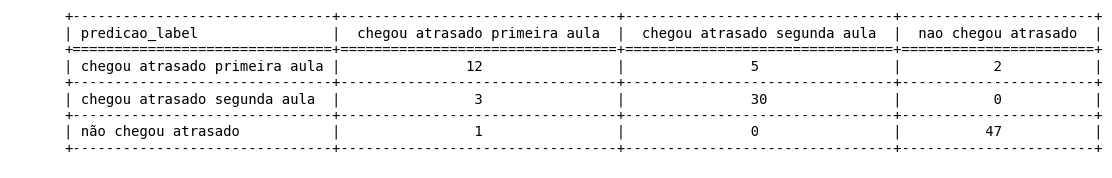

In [82]:
# In[4.8]: Visualização, para fins didáticos, do objeto 'table' (dataframe)
#no ambiente Plots

from tabulate import tabulate
tabela = tabulate(table, headers='keys', tablefmt='grid', numalign='center')

plt.figure(figsize=(7, 2))
plt.text(0.1, 0.1, tabela, {'family': 'monospace', 'size': 10})
plt.axis('off')
plt.show()

In [83]:
# In[4.9]: Eficiência global do modelo propriamente dita

# Transformando o dataframe 'table' para 'array', para que seja possível
#estabelecer o atributo 'diagonal'
table = table.to_numpy()
table

array([[12.,  5.,  2.],
       [ 3., 30.,  0.],
       [ 1.,  0., 47.]])

In [84]:
# Eficiência global do modelo
acuracia = table.diagonal().sum()/table.sum()
acuracia

0.89

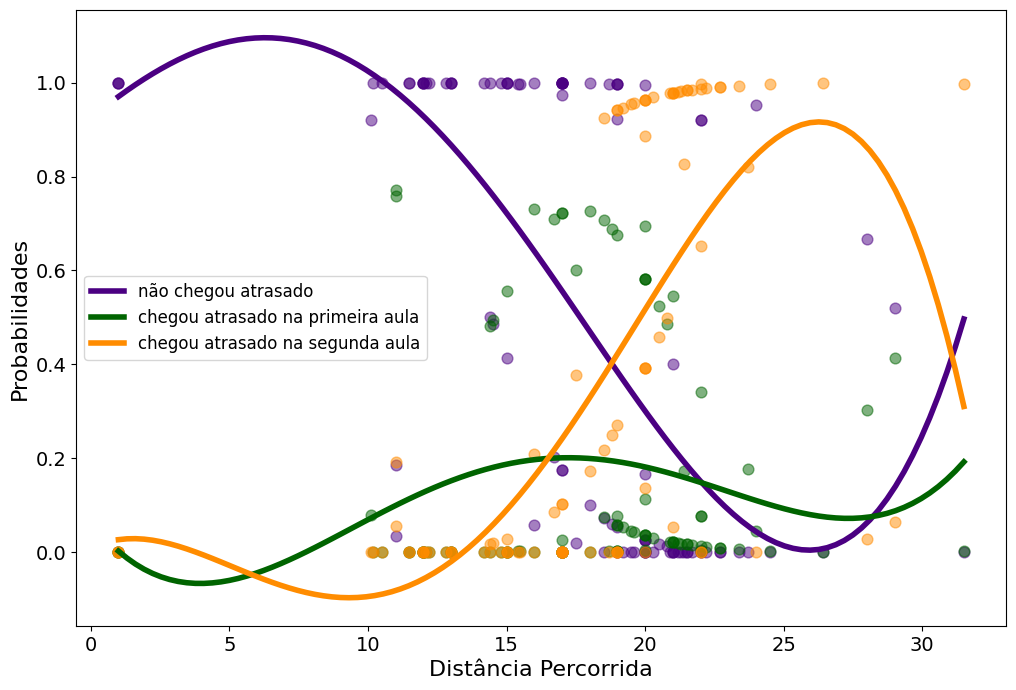

In [85]:
# In[4.10]: Plotagens das probabilidades

# Plotagem das smooth probability lines para a variável 'dist'

# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

plt.figure(figsize=(12,8))

# Plot para "não chegou atrasado"
sns.regplot(x='dist', y=df_atrasado_multinomial[0],
            data=df_atrasado_multinomial, ci=False, order=4,
            line_kws={'color':'indigo', 'linewidth':4,
                      'label':'não chegou atrasado'},
            scatter_kws={'color':'indigo', 's':60, 'alpha':0.5})

# Plot para "chegou atrasado na primeira aula"
sns.regplot(x='dist', y=df_atrasado_multinomial[1],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkgreen', 'linewidth':4,
                      'label':'chegou atrasado na primeira aula'},
            scatter_kws={'color':'darkgreen', 's':60, 'alpha':0.5})

# Plot para "chegou atrasado na segunda aula"
sns.regplot(x='dist', y=df_atrasado_multinomial[2],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkorange', 'linewidth':4,
                      'label':'chegou atrasado na segunda aula'},
            scatter_kws={'color':'darkorange', 's':60, 'alpha':0.5})

plt.xlabel('Distância Percorrida', fontsize=16)
plt.ylabel('Probabilidades', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='center left', fontsize=12)
plt.show()

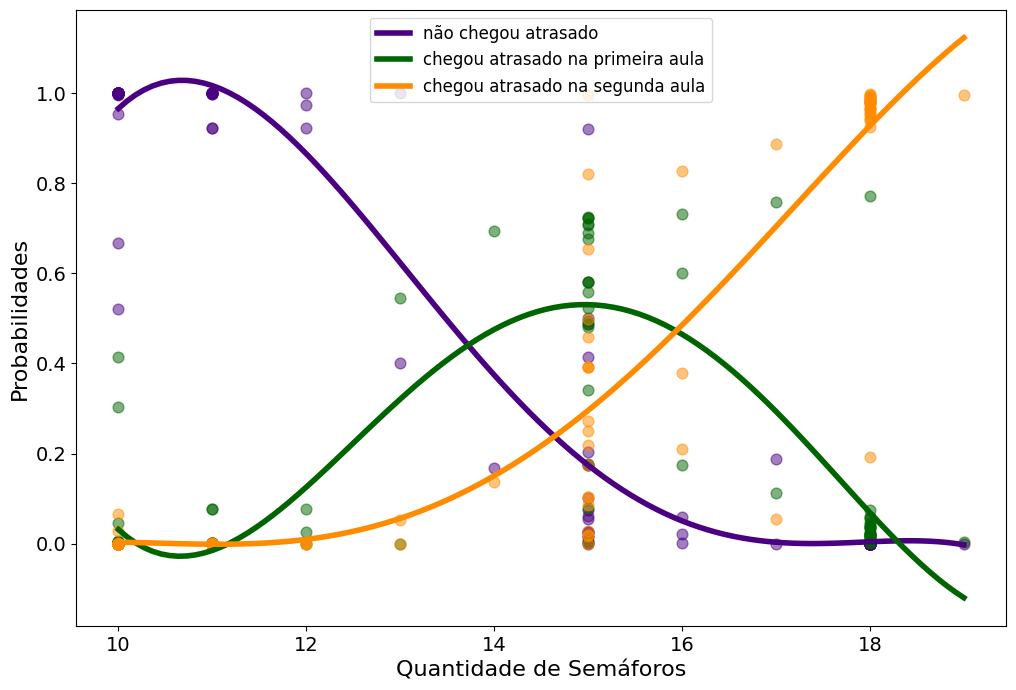

In [86]:
# In[4.11]: Plotagens das probabilidades

# Plotagem das smooth probability lines para a variável 'sem'

# 0: não chegou atrasado
# 1: chegou atrasado primeira aula
# 2: chegou atrasado segunda aula

plt.figure(figsize=(12,8))

# Plot para "não chegou atrasado"
sns.regplot(x='sem', y=df_atrasado_multinomial[0],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'indigo', 'linewidth':4,
                      'label':'não chegou atrasado'},
            scatter_kws={'color':'indigo', 's':60, 'alpha':0.5})

# Plot para "chegou atrasado na primeira aula"
sns.regplot(x='sem', y=df_atrasado_multinomial[1],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkgreen', 'linewidth':4,
                      'label':'chegou atrasado na primeira aula'},
            scatter_kws={'color':'darkgreen', 's':60, 'alpha':0.5})

# Plot para "chegou atrasado na segunda aula"
sns.regplot(x='sem', y=df_atrasado_multinomial[2],
            data=df_atrasado_multinomial, ci=None, order=4,
            line_kws={'color':'darkorange', 'linewidth':4,
                      'label':'chegou atrasado na segunda aula'},
            scatter_kws={'color':'darkorange', 's':60, 'alpha':0.5})

plt.xlabel('Quantidade de Semáforos', fontsize=16)
plt.ylabel('Probabilidades', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', fontsize=12)
plt.show()

In [87]:
# In[4.12]: Plotagem tridimensional para cada probabilidade de ocorrência de
#cada categoria da variável dependente

# Probabilidades de não se chegar atrasado (função 'go' do pacote 'plotly')

#pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[0],
    opacity=1, intensity=df_atrasado_multinomial[0],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='não chegou atrasado'))

plot_figure.show()

In [88]:
# In[4.13]: Plotagem tridimensional para cada probabilidade de ocorrência de
#cada categoria da variável dependente

# Probabilidades de se chegar atrasado à primeira aula (função 'go' do pacote
#'plotly')

#pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[1],
    opacity=1, intensity=df_atrasado_multinomial[1],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='chegou atrasado à primeira aula'))

plot_figure.show()

In [89]:
# In[4.14]: Plotagem tridimensional para cada probabilidade de ocorrência de
#cada categoria da variável dependente

# Probabilidades de se chegar atrasado à segunda aula (função 'go' do pacote
#'plotly')

#pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[2],
    opacity=1, intensity=df_atrasado_multinomial[2],
    colorscale="Viridis")

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plot_figure.update_layout(scene = dict(
                        xaxis_title='dist',
                        yaxis_title='sem',
                        zaxis_title='chegou atrasado à segunda aula'))

plot_figure.show()

In [90]:
# In[4.15]: Visualização das sigmoides tridimensionais em um único gráfico

#pio.renderers.default = 'browser'

trace = go.Mesh3d(
    x=df_atrasado_multinomial['dist'], 
    y=df_atrasado_multinomial['sem'],
    z=df_atrasado_multinomial[0],
    opacity=1,
    color='indigo')

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    width=800,
    height=800
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

trace_1 = go.Mesh3d(
            x=df_atrasado_multinomial['dist'], 
            y=df_atrasado_multinomial['sem'],
            z=df_atrasado_multinomial[1],
            opacity=1,
            color='darkgreen')

plot_figure.add_trace(trace_1)

trace_2 = go.Mesh3d(
            x=df_atrasado_multinomial['dist'], 
            y=df_atrasado_multinomial['sem'],
            z=df_atrasado_multinomial[2],
            opacity=1,
            color='darkorange')


plot_figure.add_trace(trace_2)

plot_figure.update_layout(
    template='plotly_dark',
    scene = dict(
        xaxis_title='dist',
        yaxis_title='sem',
        zaxis_title='probabilidades')
    )

plot_figure.show()

################################## FIM ######################################